In [1]:
#VAE example, based on the Keras VAE example

%pylab inline
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import librosa
from IPython.display import Audio
import soundfile as sf


Populating the interactive namespace from numpy and matplotlib


2022-01-19 18:19:28.786484: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
sr = 44100
y = librosa.load("Tremblay-CEL-GlitchyMusicBoxMelo.wav", sr=sr)[0]

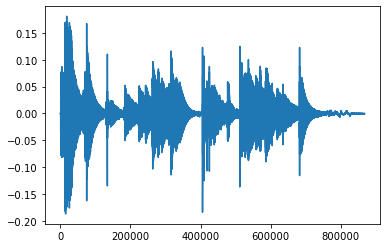

In [3]:
plot(y)

In [4]:
Audio(y, rate=sr)

In [5]:
fftsize=1024
D = librosa.stft(y, n_fft=fftsize, hop_length=128)
Dmags = librosa.amplitude_to_db(np.abs(D),ref=np.max)

/home/ck84/miniconda3/envs/conda3/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/ck84/miniconda3/envs/conda3/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/ck84/miniconda3/envs/conda3/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


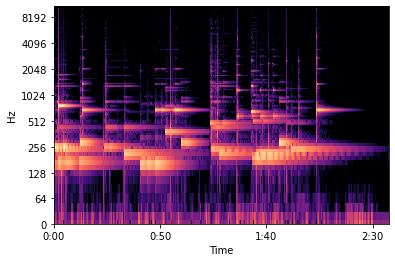

In [6]:
from librosa import display
librosa.display.specshow(Dmags,y_axis='log', x_axis='time')

In [7]:
#check dimensions
Dmags.shape

(513, 6777)

In [8]:
Dnt = Dmags.T

In [9]:
Dnt.shape

(6777, 513)

In [38]:
#remap into new array, and normalise
Dn = zeros((Dnt.shape[0], 512))

In [13]:
for i in range(Dn.shape[0]):
    Dn[i] = np.reshape(Dnt[i][:512], (512))

In [14]:
Dn = Dn + np.abs(np.min(Dn))
Dn = Dn / np.max(Dn)

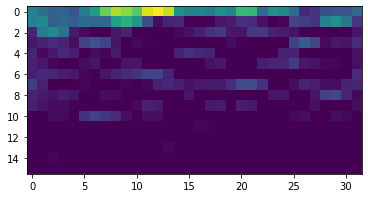

In [21]:
#take a look at one of the spectra
imshow(np.reshape(Dn[100], (16,32)))

In [22]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [23]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(512, 1))
# x = layers.Reshape((32*32,1))(encoder_inputs)
x = layers.Conv1D(16, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv1D(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 1)]     0                                            
______________________________________________________________________________________

2022-01-19 18:21:52.814167: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-01-19 18:21:54.025455: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-19 18:21:54.025493: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cslp021190): /proc/driver/nvidia/version does not exist
2022-01-19 18:21:54.026110: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-19 18:21:54.042143: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2400000000 Hz
2022-01-19 18:21:54.042489: I tensorflo

In [25]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128*32, activation="relu")(latent_inputs)
x = layers.Reshape((128, 32))(x)
x = layers.Conv1DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv1DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv1DTranspose(1, 3, activation="sigmoid", padding="same")(x)
# decoder_outputs = layers.Reshape((32,32,1))(decoder_outputs)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              12288     
_________________________________________________________________
reshape_1 (Reshape)          (None, 128, 32)           0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 256, 32)           3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 512, 16)           1552      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 512, 1)            49        
Total params: 16,993
Trainable params: 16,993
Non-trainable params: 0
_______________________________________________________

In [26]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
#                     keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [27]:
Dn_set = np.expand_dims(Dn, -1)
Dn_set.shape

(6777, 512, 1)

In [29]:
#training
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(Dn_set, epochs=30, batch_size=128)


Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
53/53 [==============================] - 1s 20ms/step - loss: 50.2223 - reconstruction_loss: 46.7932 - kl_loss: 2.5749
Epoch 2/30
53/53 [==============================] - 1s 19ms/step - loss: 50.6757 - reconstruction_loss: 46.5687 - kl_loss: 2.5903
Epoch 3/30
53/53 [==============================] - 1s 25ms/step - loss: 48.6841 - reconstruction_loss: 46

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


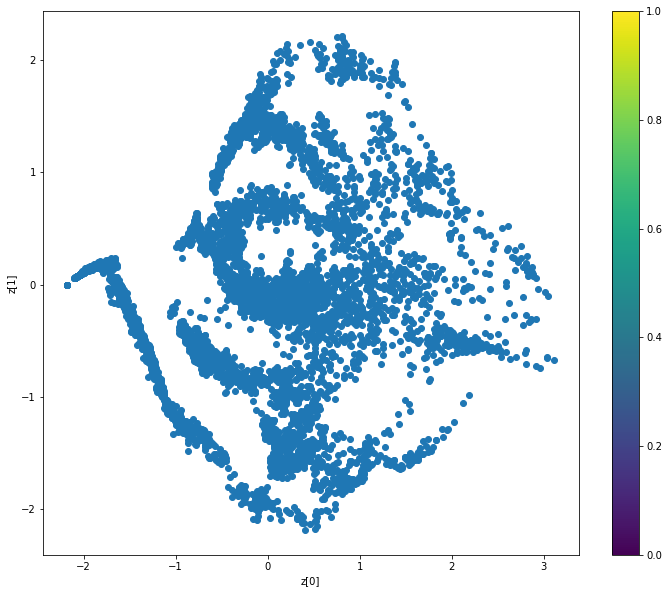

In [30]:
#look at the stucture of the latent space
def plot_label_clusters(vae, data):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1])
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()



plot_label_clusters(vae, Dn_set)


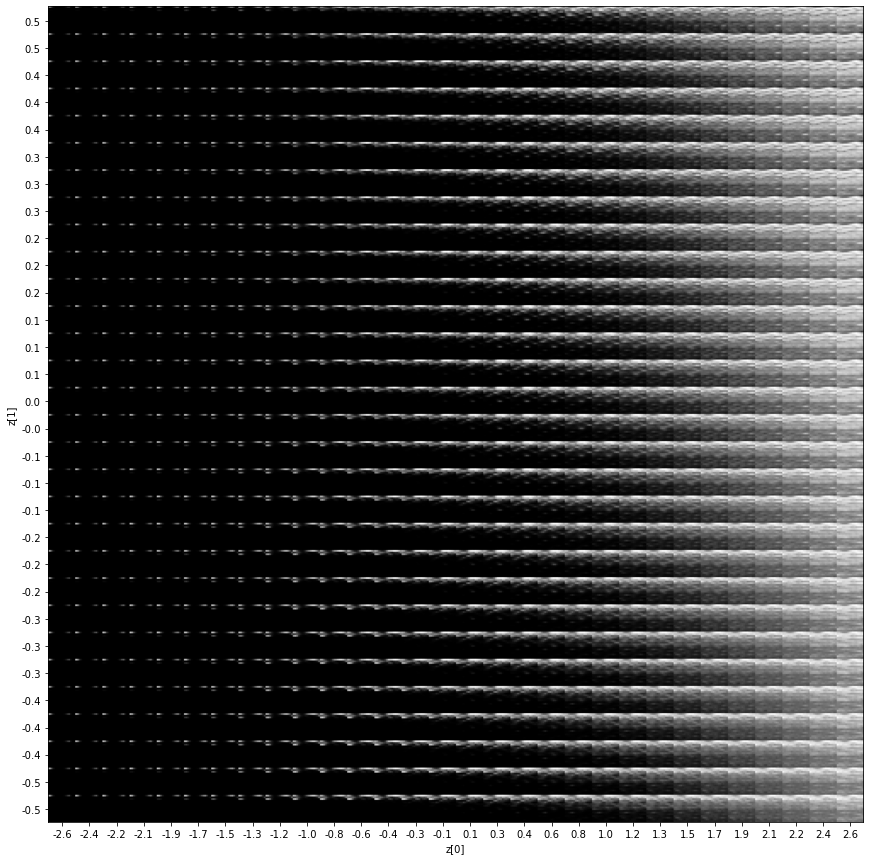

In [34]:

#map out the latent space

def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 16
    scalex = 2.6
    scaley=0.5
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scalex, scalex, n)
    grid_y = np.linspace(-scaley, scaley, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0][:256].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)



In [35]:
vae.encoder.save('musicbox.vae.encoder.model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-01-19 18:35:48.882152: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: musicbox.vae.encoder.model/assets


In [36]:
vae.decoder.save('musicbox.vae.decoder.model')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: musicbox.vae.decoder.model/assets
